In [21]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

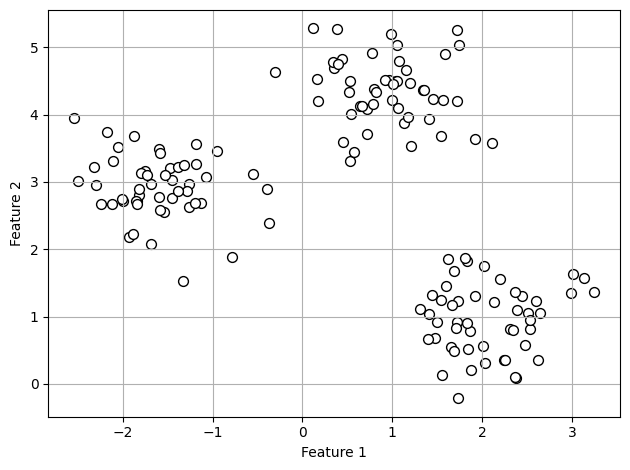

In [2]:
# create sample data with 2 features, 3 clusters
X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5, shuffle=True, random_state=0)

# plot data
plt.scatter(X[:, 0], X[:, 1], c='white', marker='o', edgecolor='black', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.tight_layout()
plt.show()

# K-Means

In [3]:
# K = 3, random init center 10 models, train each max_iter times, and select best
# init = k-means++ will init the centers far from each other, and is usually preferred
km = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-4, random_state=0)
y_km = km.fit_predict(X)

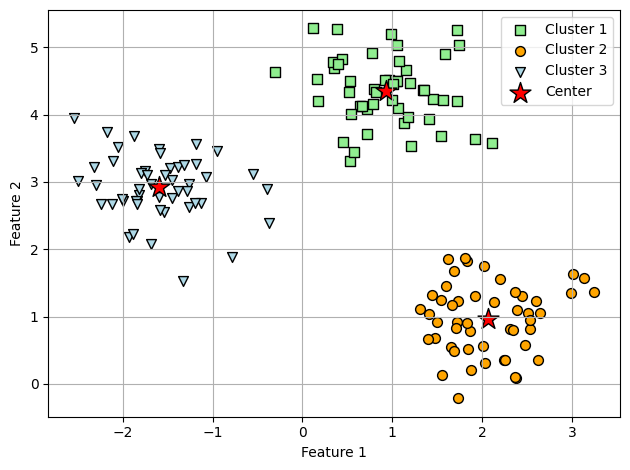

In [4]:
# visualize each cluster data
plt.scatter(X[y_km == 0, 0], X[y_km == 0, 1], s=50, c='lightgreen', marker='s', edgecolor='black', label='Cluster 1')
plt.scatter(X[y_km == 1, 0], X[y_km == 1, 1], s=50, c='orange', marker='o', edgecolor='black', label='Cluster 2')
plt.scatter(X[y_km == 2, 0], X[y_km == 2, 1], s=50, c='lightblue', marker='v', edgecolor='black', label='Cluster 3')

# visualize cluster center
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black', label='Center')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

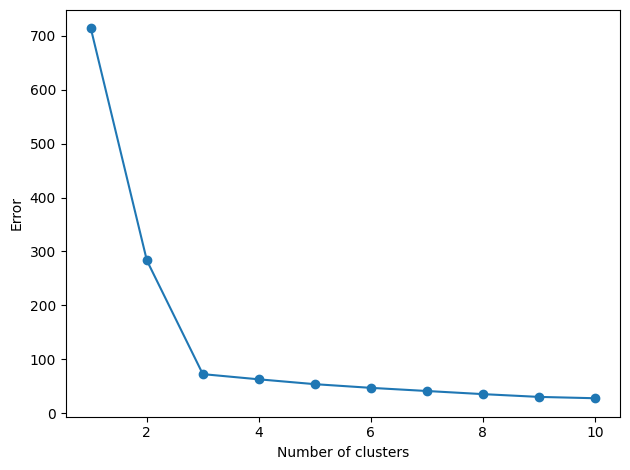

In [5]:
# use the elbow method, which plots within-cluster distance (less is better) vs number of clusters, to help decide optimal k

errors = []

# check up to 11 clusters
for i in range (1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(X)
    # append the error
    errors.append(km.inertia_)

# elbow plot
plt.plot(range(1, 11), errors, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Error')
plt.tight_layout()
plt.show()

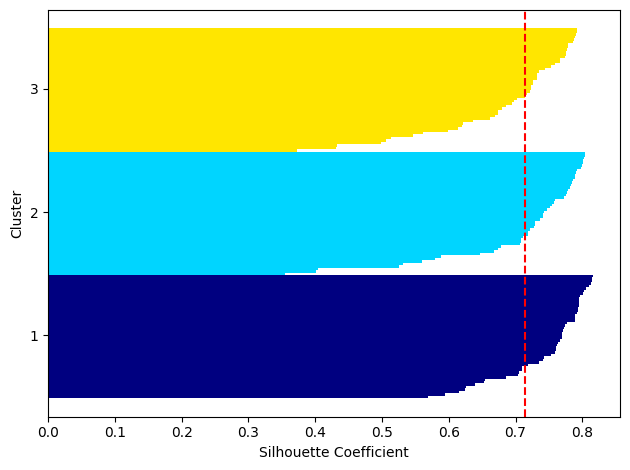

In [6]:
# silhouette plots show the silhouette coefficients, which shows how close the samples are in each cluster (1 is optimal)

# train a k-means model and predict
km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=0)
y_km = km.fit_predict(X)

# calculate the silhouette coefficients
silhouette_coefs = silhouette_samples(X, y_km, metric='euclidean')

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

# keep track of how vertical to draw each cluster
y_ax_lower, y_ax_upper = 0, 0

yticks = []

for i, cluster in enumerate(cluster_labels):
    # get all the coefs for this cluster, and sort
    cluster_silhouette_coefs = silhouette_coefs[y_km == cluster]
    cluster_silhouette_coefs.sort()

    y_ax_upper += len(cluster_silhouette_coefs)
    color = cm.jet(float(i) / n_clusters)
    # plot one bar for each sample's coefs
    plt.barh(range(y_ax_lower, y_ax_upper), cluster_silhouette_coefs, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(cluster_silhouette_coefs)

# plot average of all coeffs of all clusters
silhouette_avg = np.mean(silhouette_coefs)
plt.axvline(silhouette_avg, color='red', linestyle='--')

plt.yticks(yticks, cluster_labels+1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette Coefficient')
plt.tight_layout()
plt.show()

# Hierarchical Clustering

In [8]:
# create sample dataset
np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']
X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


In [11]:
# compute the pair-wise distance matrix between samples
dist_matrix = pd.DataFrame(squareform(pdist(df, metric='euclidean')), columns=labels, index=labels)
dist_matrix

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [13]:
# compute the complete linkage clustering
row_clusters = linkage(df.values, method='complete', metric='euclidean')

# visualize clustering
pd.DataFrame(row_clusters, columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'], index=[f'cluster {(i + 1)}' for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


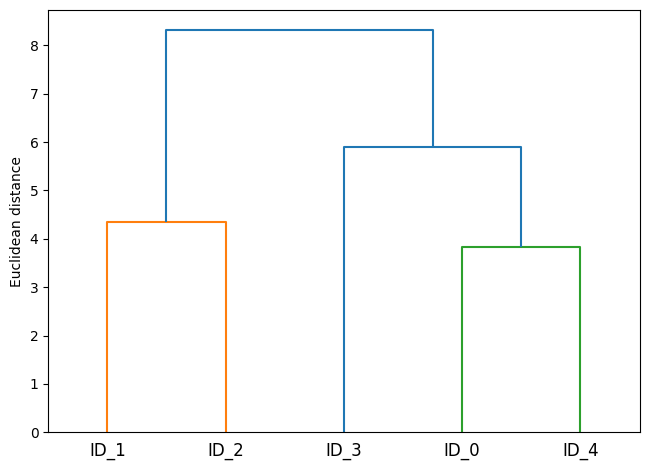

In [15]:
# plot dendrogram
row_dendr = dendrogram(row_clusters, labels=labels)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

In [17]:
# or use sklearn, can choose how many clusters we want
ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
labels = ac.fit_predict(X)
print(f'Cluster labels: {labels}')

Cluster labels: [1 0 0 2 1]


# DBSCAN

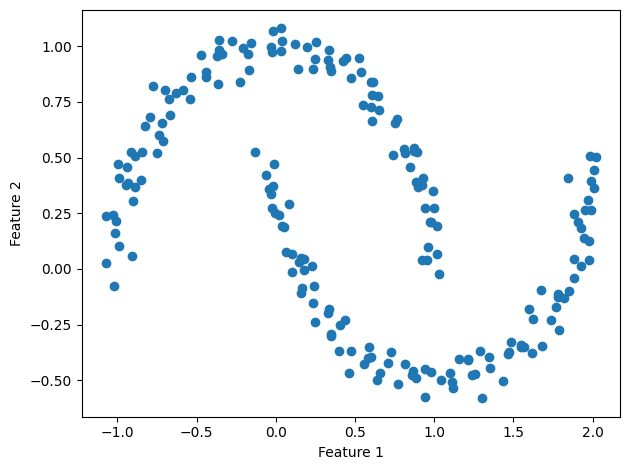

In [19]:
# create sample dataset
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()

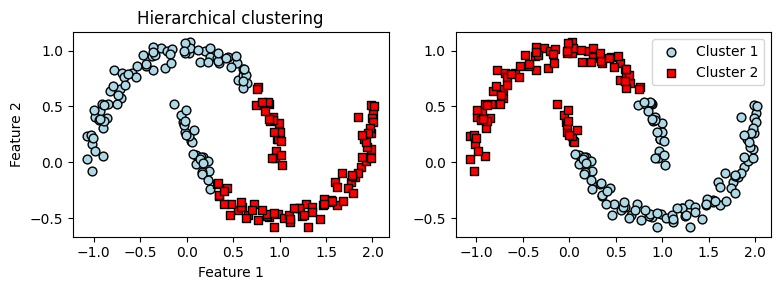

In [20]:
# test this dataset clustering using k-means and hierarchical clustering

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1], s=40, c='lightblue', marker='o', edgecolor='black', label='Cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1], s=40, c='red', marker='s', edgecolor='black', label='Cluster 2')
ax1.set_title('K-Means')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], s=40, c='lightblue', marker='o', edgecolor='black', label='Cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], s=40, c='red', marker='s', edgecolor='black', label='Cluster 2')
ax1.set_title('Hierarchical clustering')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

plt.legend()
plt.tight_layout()
plt.show()

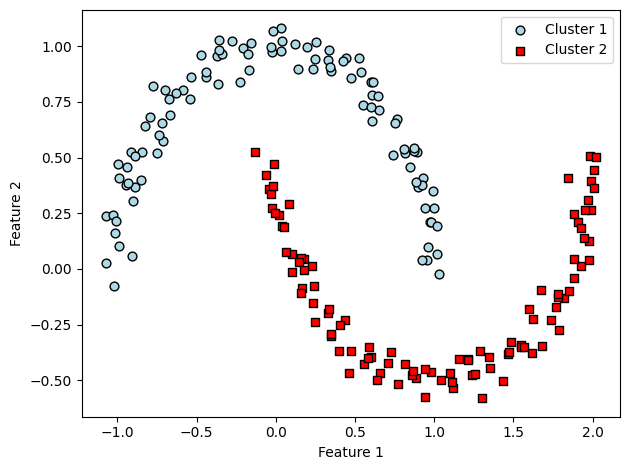

In [24]:
# density-based clustering using DBSCAN
db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1], s=40, c='lightblue', marker='o', edgecolor='black', label='Cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1], s=40, c='red', marker='s', edgecolor='black', label='Cluster 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()
plt.show()